In [1]:
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('../data/Mnist/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/Mnist/train-images-idx3-ubyte
../data/Mnist/t10k-images-idx3-ubyte
../data/Mnist/train-labels-idx1-ubyte
../data/Mnist/t10k-labels-idx1-ubyte


In [2]:
training_images_filepath ='../data/Mnist/train-images-idx3-ubyte'
training_labels_filepath ='../data/Mnist/train-labels-idx1-ubyte'
test_images_filepath = '../data/Mnist/t10k-images-idx3-ubyte'
test_labels_filepath = '../data/Mnist/t10k-labels-idx1-ubyte'

In [3]:
sys.path.append('../src/')
from Mnist_Utils import MnistDataloader,show_images
' Load Mnist data '

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

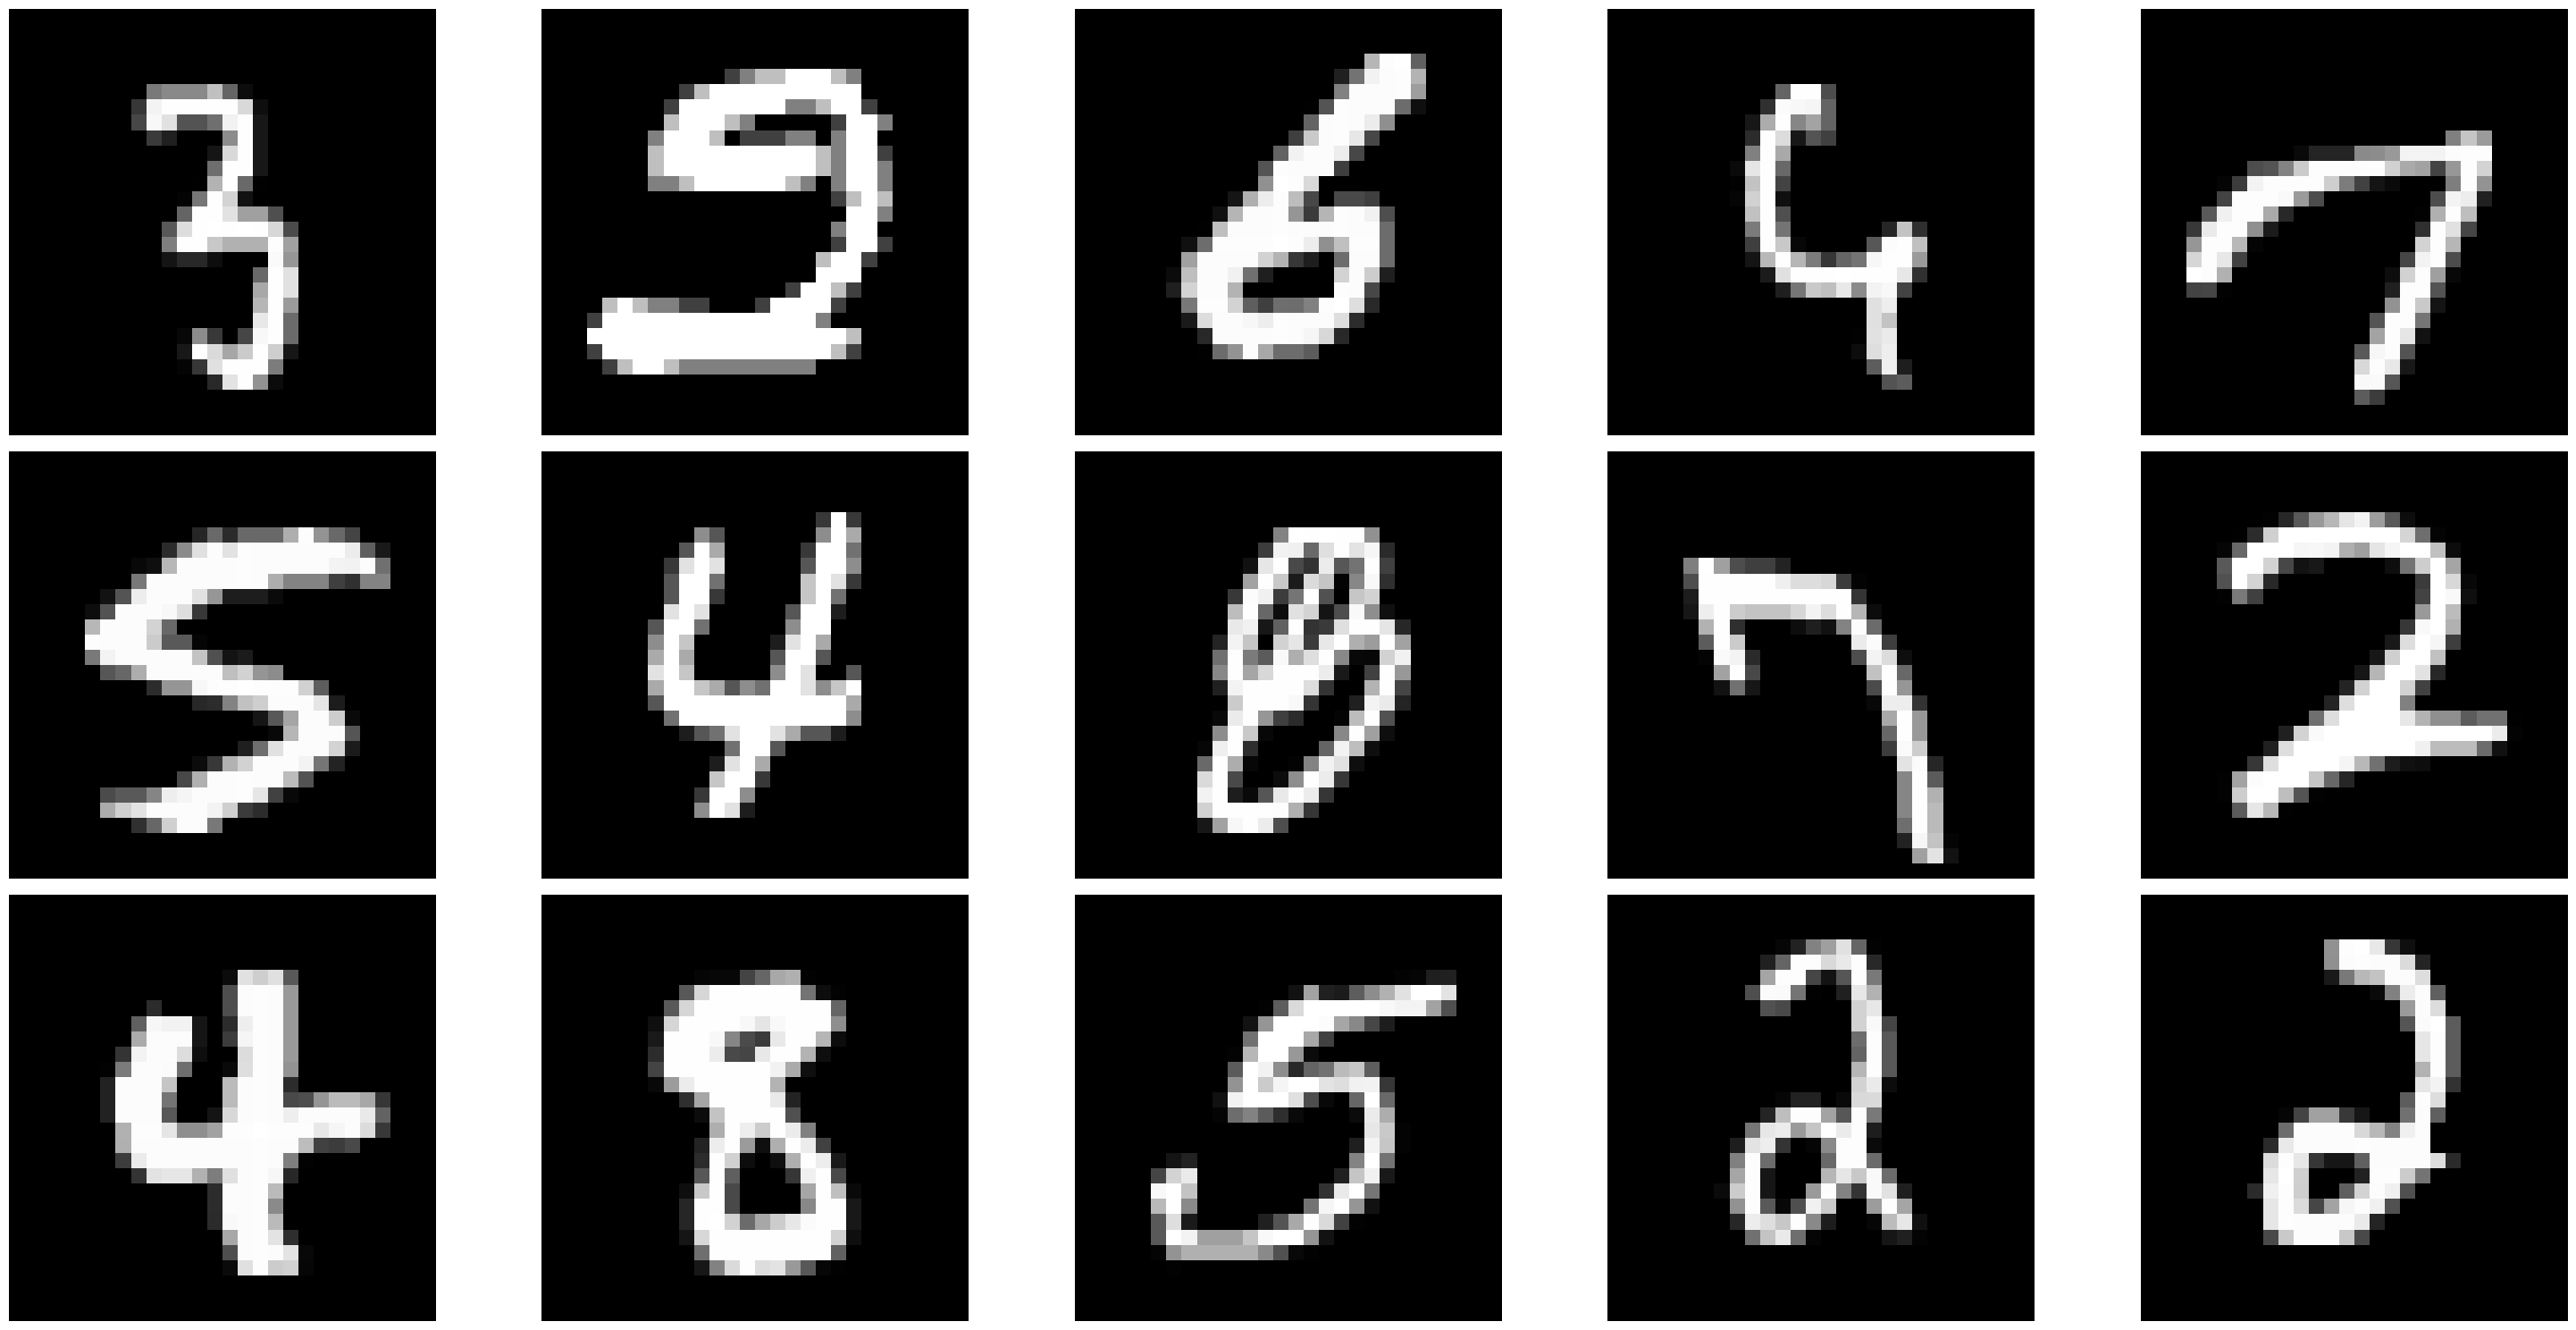

In [4]:


' Load MINST dataset '

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
' Show some random training and test images ' 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('') 
    #titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('') 
    #titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)



In [5]:
' Choose subset of test images as nodes for the adjucency graph '

Mnist_Train = pd.DataFrame(data= {'data': x_train,'labels': y_train})
y = Mnist_Train.loc[:,'labels'].values
x = Mnist_Train.loc[:,'data':].values

x_subset = x[0:400,:]
x_subset = np.concatenate(x_subset[:,0]).reshape(400,784)
y_subset = y[0:400]

print(np.unique(y_subset))

[0 1 2 3 4 5 6 7 8 9]


# K-Ball Tree Datastrucutre with Euclidian or Wasserstein Distance 

In [6]:
from scipy.spatial.distance import euclidean
from scipy.sparse import csr_matrix
from sklearn.neighbors import BallTree
from scipy.stats import wasserstein_distance

In [7]:
Indices_Random = np.random.choice(400,400,replace=False)
Data_Vis = x_subset[Indices_Random]
Labels_Vis = y_subset[Indices_Random]
Data_Vis = Data_Vis/np.sum(Data_Vis,axis=1)[:,None]

# Define the Wasserstein distance as a custom metric
def wasserstein_metric(u, v):
    # u and v are two points in the space (distributions)
    return wasserstein_distance(u, v)

In [8]:
' Set up the Ball-tree using Euclidian Metric using 10 nearest neighbours '
tree = BallTree(Data_Vis, leaf_size=2, metric= 'euclidean')

# Query for k-nearest neighbors (including self-loops)
k = 10
Knn_distance, Knn_indices = tree.query(Data_Vis, k=k)




# Adjucency Matrix 

In [9]:
from Graph_Build import FM_Ad_Matrix_Graph,Check_Graph_Components

adjacency_matrix = FM_Ad_Matrix_Graph(Data_Vis,Knn_indices, Knn_distance)
Check_Graph_Components(adjacency_matrix)

Graph is already fully connected.
Sparse adjacency matrix with one connected component created!
The graph is fully connected.


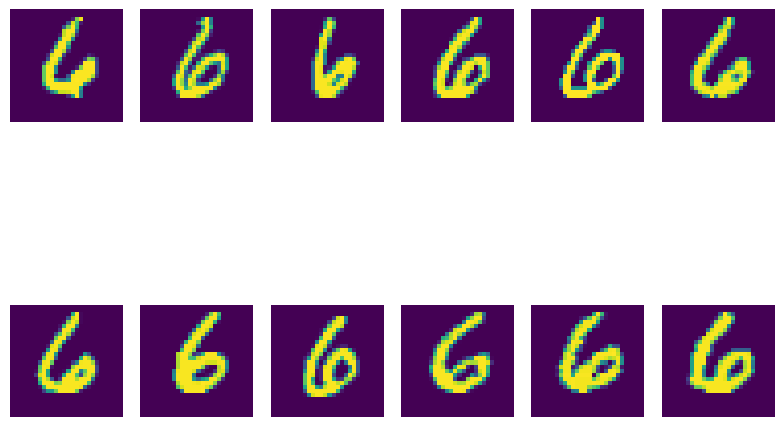

In [29]:
' Show the k-nearest neighbour nodes '


k = 2 # Choose an Index
# Extract neighbors for the k-th point
symmetric_indices = adjacency_matrix.indices[adjacency_matrix.indptr[k]:adjacency_matrix.indptr[k+1]]

# Check if indices are valid
assert len(symmetric_indices) > 0, "No neighbors found for the specified index."
assert Data_Vis.shape[1] == 28 * 28, "Data points must have 784 features to reshape into 28x28."

# Number of neighbors and subplot setup
n_neighbors = len(symmetric_indices)
fig, axes = plt.subplots(2, 6, figsize=(8, 8))
axes = axes.flatten()  # Flatten axes array into 1D

# Iterate over neighbors and plot
for i in range(min(len(axes), n_neighbors)):
    ax = axes[i]
    ax.imshow(Data_Vis[symmetric_indices[i]].reshape(28, 28), cmap='viridis')  # Plot the image
    ax.axis('off')  # Turn off the axis

# Hide unused subplots
for i in range(n_neighbors, len(axes)):
    axes[i].axis('off')

fig.tight_layout()
plt.show()




# Plot the kNN-Adjucency Graph 

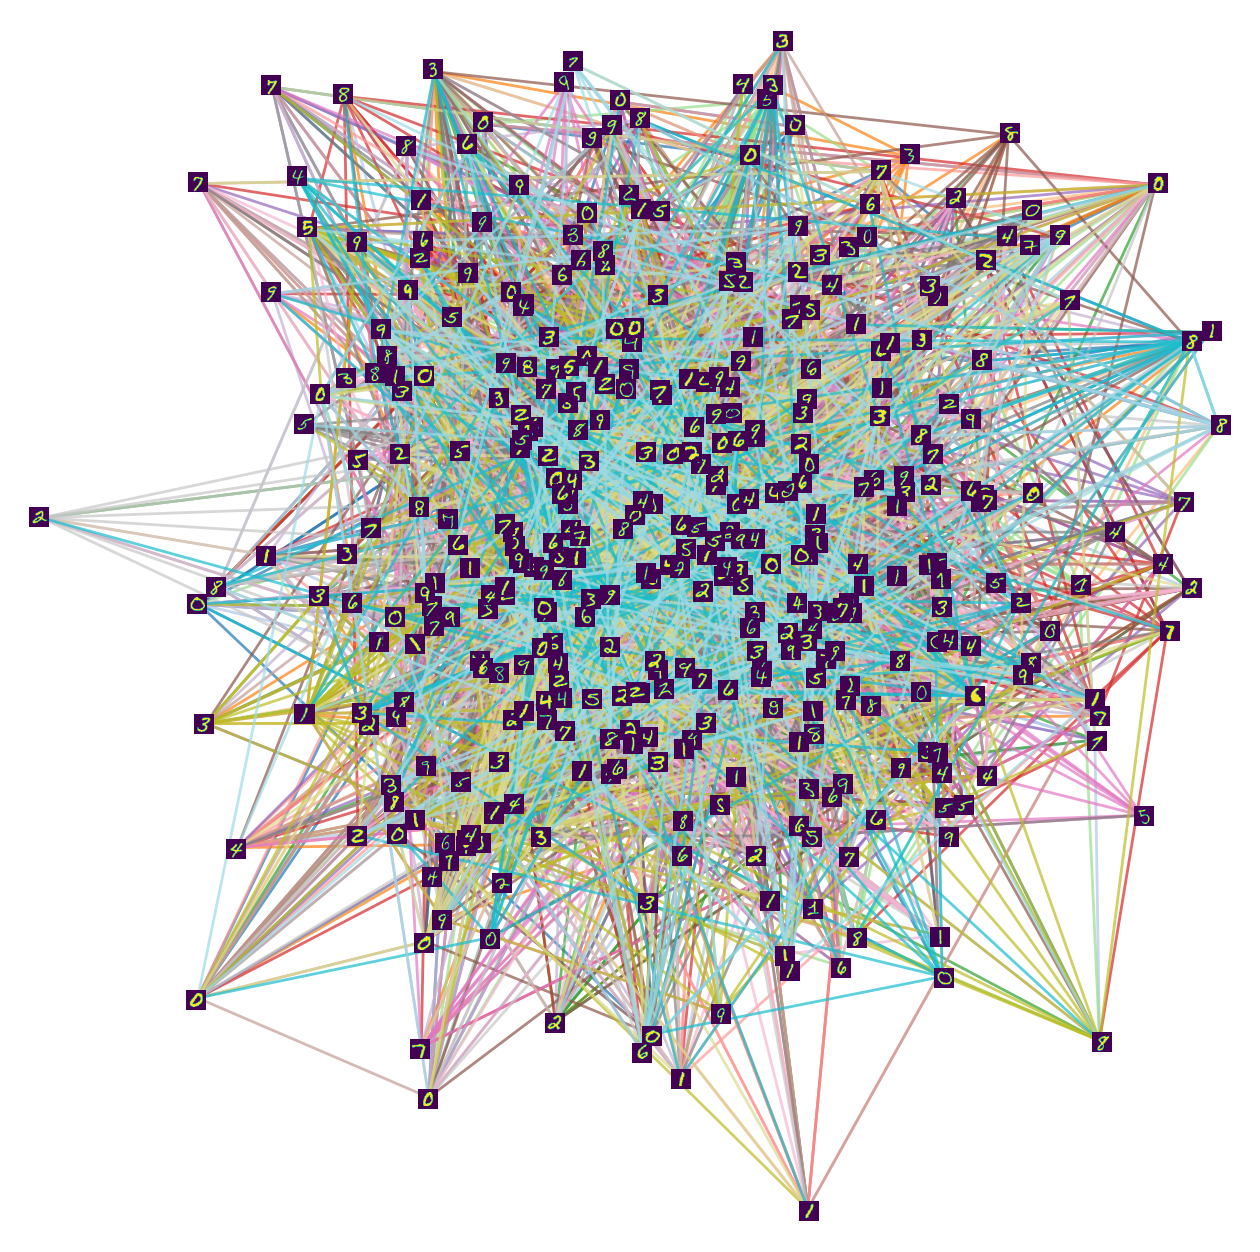

In [12]:
from Visualize_Front import Visualize_Knn_Graph

data_2d,G = Visualize_Knn_Graph(Data_Vis,Knn_indices)

In [30]:
##sys.path.append('../src/Fast_Marching_Cython/')
#import Fast_Marching_Eikonal

Arrival_Times = np.ones(Data_Vis.shape[0])*1e10

' Initialize Index List for Front Propagation for each representative digit [0,1,2,3,4,5,6,7,8,9] within the data set '

Indices = [np.where(Labels_Vis == k)[0][0:2] for k in range(8,9)]
Indices = Indices[0][1]

' Initialize Labels '

Labeling = np.zeros(Data_Vis.shape[0])
#dim = 0
#for k in range(1):
#    Labeling[Indices[k]] = k 
#    dim+=Indices[k].shape[0]
Ind = np.zeros((1,2)).astype(np.intc)
#start_ind = 0
#for k in range(1): 
#    Ind[start_ind:start_ind+Indices[k].shape[0],0] = Indices[k]
#    start_ind += Indices[k].shape[0]
Ind[:,0] = Indices
Arrival_Times.reshape(-1)[Ind[:,0]] = 0
Ind[:,1] = 1

' Initialize Velocities for Front Propagation based on the Distance Matrix '

Ind[0,0] = 2

Vel = np.array([np.ones(Data_Vis.shape[0]) for k in range (2)]) 
Vel = Vel[0,:]
for k in range(Data_Vis.shape[0]):
    Vel[k] = np.exp(-euclidean(Data_Vis[Ind[0,0]],Data_Vis[k]))


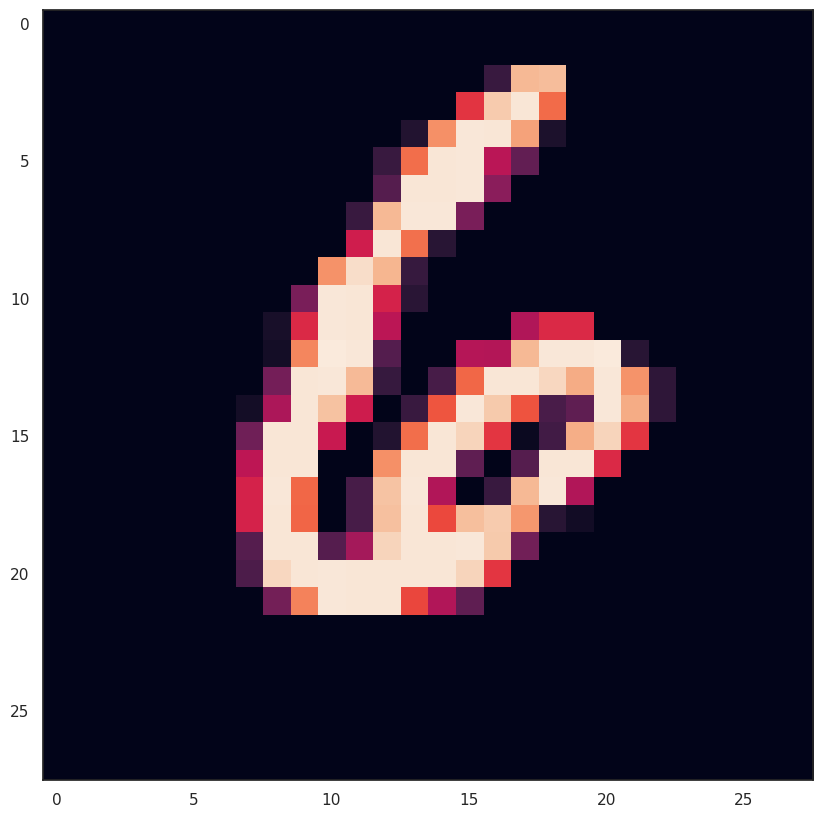

In [31]:
' Show Random Seed Points '

plt.imshow(Data_Vis[Ind[0,0]].reshape(28,28))

In [35]:
sys.path.append('home/dmitrij/Documents/HDE_Code_Folder/FM_Eikonal/src/')
from Fast_Marching_Cython import Fast_Marching_Eikonal

' Compute Labelings for each norm instance (Infinity (Djakstra,L_1 Norm,Euclidian))'
Test_1,Test_2 = Fast_Marching_Eikonal.Eikonal_Eq_Solve_Cython(Arrival_Times.reshape(-1),Vel,adjacency_matrix.data,adjacency_matrix.indices,adjacency_matrix.indptr,Ind,p = 1.0)
#Lab_one,Active_List_one,Active_Val_one = Fast_Marching_Eikonal.Eikonal_Eq_Labeling_Cython(Labeling,Arrival_Times.reshape(-1),Vel,Ad.data,Ad.indices,Ad.indptr,Ind,np.array([3,3,3]).astype(np.intc),p = 1.0)
#Lab_Euc,Active_List_Euc,Active_Val_Euc = Fast_Marching_Eikonal.Eikonal_Eq_Labeling_Cython(Labeling,Arrival_Times.reshape(-1),Vel,Ad.data,Ad.indices,Ad.indptr,Ind,np.array([3,3,3]).astype(np.intc),p = 2.0)

Computation finished in ___0.0689997673034668___seconds


In [37]:
# Show the tracked data points
'''fig,axes = plt.subplots(50,8,figsize = (24,24))
axes = axes.flatten()
for k in range(len(Test_1[0:400])):
    ax = axes[k]
    ax.imshow(Data_Vis[Test_1[k],:].reshape(28,28))
    ax.set_title(str(Labels_Vis[Test_1[k]]))
    ax.axis('off')
'''
    



"fig,axes = plt.subplots(50,8,figsize = (24,24))\naxes = axes.flatten()\nfor k in range(len(Test_1[0:400])):\n    ax = axes[k]\n    ax.imshow(Data_Vis[Test_1[k],:].reshape(28,28))\n    ax.set_title(str(Labels_Vis[Test_1[k]]))\n    ax.axis('off')\n"

In [36]:
import importlib
import Visualize_Front
importlib.reload(Visualize_Front)

#from Visualize_Front import create_propagation_gif
' Create Annimation of Front Propagation '

Visualize_Front.create_propagation_gif(data_2d,G,Data_Vis,Knn_indices,Test_1)

Wave propagation GIF saved as wave_propagation.gif
